### Overview of the Problem:
Traffic flow prediction plays a crucial role in managing urban mobility and optimizing transportation systems. By forecasting traffic patterns, cities can reduce congestion, improve travel times, and enhance overall road safety. This project aims to develop a machine learning model to predict traffic flow across various locations in a city, assisting urban planners and transportation authorities in making data-driven decisions.

### Dataset Explanation:
The project utilizes the METR-LA dataset, a real-world traffic dataset collected from a network of 207 traffic sensors deployed across Los Angeles. These sensors record traffic speeds at various locations throughout the city, providing valuable spatio-temporal data for traffic flow analysis.

### Data Structure:
Rows: Represent time intervals at which traffic data is recorded.
Columns: Represent traffic sensors (207 nodes) distributed across the city, each capturing traffic speed at a specific location.
Temporal Aspect: The dataset spans multiple days, capturing daily and seasonal variations in traffic flow.
The dataset includes both spatial dependencies (how traffic flow is correlated across different locations) and temporal dependencies (how traffic flow changes over time).

### Objective:
The goal of this project is to predict future traffic flow at each of the 207 sensors using historical data. The project compares four models to determine the most effective approach:

1.Graph Convolutional Networks (GCN) – A spatial model that captures
relationships between different traffic sensors.

2.Long Short-Term Memory (LSTM) – A temporal model that learns from past traffic flow patterns to predict future values.

3.Spatio-Temporal Convolutional Networks (ST-CNN) – A model that combines both spatial and temporal information to predict traffic flow.

4.Spatio-Temporal Graph Convolutional Networks (ST-GCN) – A model designed to handle spatio-temporal data by capturing both spatial dependencies among the sensors and temporal patterns in traffic flow.

By comparing these models, the aim is to identify the most accurate and efficient approach for traffic flow prediction using the METR-LA dataset with its 207 sensors.



In [1]:
# Data manipulation and numerical operations
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

# Data scaling and transformation
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt

# File handling (e.g., saving/loading models)
import os
import pickle as pk

# Libraries for model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For handling time-series data
import h5py

# For handling device (CPU/GPU) in PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Additional imports for time series and graph-based models
import networkx as nx

# Print the device being used
print(f"Using device: {device}")

Using device: cuda


### Dataset Exploration:

In [12]:
X = np.load("data/node_values.npy").transpose((1, 2, 0))

# Accessing raw data for Node 0
raw_data_node_0 = X[0, 0, :]

# Display the first 10 values for a quick look at the data
print(raw_data_node_0[:10])  # Displaying the first 10 time steps for Node 0

[64.375      62.66666667 64.          0.          0.         57.33333333
 66.5        63.625      68.75       63.5       ]


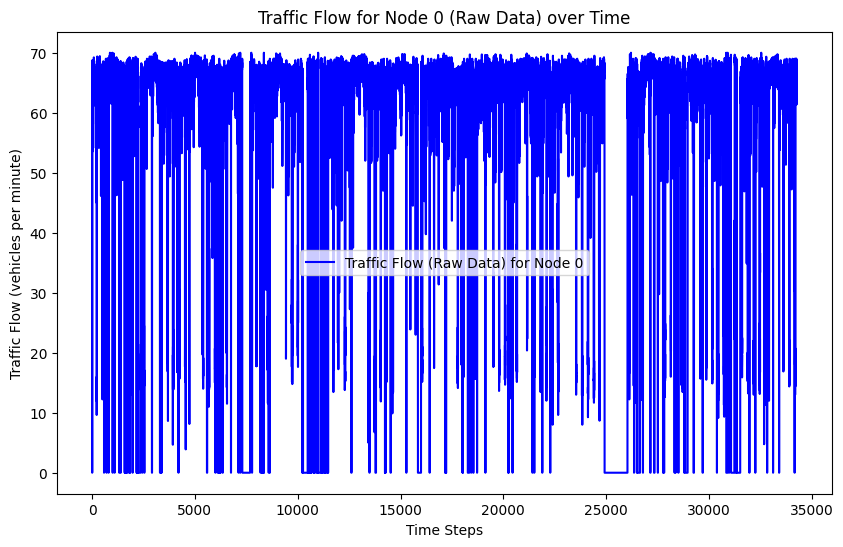

In [13]:
# Visualizing the Traffic Flow for Node 0 (Raw Data)
plt.figure(figsize=(10, 6))
plt.plot(raw_data_node_0, label='Traffic Flow (Raw Data) for Node 0', color='blue')
plt.title("Traffic Flow for Node 0 (Raw Data) over Time")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Flow (vehicles per minute)")
plt.legend()
plt.show()

In [6]:
# Function to load METR-LA data
def load_metr_la_data():
    if not os.path.isfile("data/adj_mat.npy") or not os.path.isfile("data/node_values.npy"):
        with zipfile.ZipFile("data/METR-LA.zip", 'r') as zip_ref:
            zip_ref.extractall("data/")

    # Load adjacency matrix and node values
    A = np.load("data/adj_mat.npy")
    X = np.load("data/node_values.npy").transpose((1, 2, 0))  # Transpose to (nodes, features, time_steps)
    X = X.astype(np.float32)

    # Normalization using Z-score
    means = np.mean(X, axis=(0, 2))  # Mean for each feature across time and nodes
    X = X - means.reshape(1, -1, 1)
    stds = np.std(X, axis=(0, 2))  # Standard deviation for each feature across time and nodes
    X = X / stds.reshape(1, -1, 1)

    return A, X, means, stds

# Load data
A, X, means, stds = load_metr_la_data()

# Check the shape of the data to verify
print("Shape of adjacency matrix A:", A.shape)
print("Shape of the node values X:", X.shape)


Shape of adjacency matrix A: (207, 207)
Shape of the node values X: (207, 2, 34272)


In [7]:
# The shape of X is (num_nodes, num_features, num_time_steps)
num_nodes, num_features, num_time_steps = X.shape
print(f"Number of nodes (sensors): {num_nodes}")
print(f"Number of features: {num_features}")
print(f"Number of time steps: {num_time_steps}")

# Let's inspect the first few values for the first node to get a sense of the data
print("First 5 time steps of feature 0 (Traffic Flow) for node 0:")
print(X[0, 0, :5])  # Traffic flow for the first node
print("First 5 time steps of feature 1 (Occupancy) for node 0:")
print(X[0, 1, :5])  # Occupancy for the first node


Number of nodes (sensors): 207
Number of features: 2
Number of time steps: 34272
First 5 time steps of feature 0 (Traffic Flow) for node 0:
[ 0.53317183  0.44864222  0.51461655 -2.6521542  -2.6521542 ]
First 5 time steps of feature 1 (Occupancy) for node 0:
[-1.7291821 -1.7171322 -1.7050823 -1.6930324 -1.6809825]


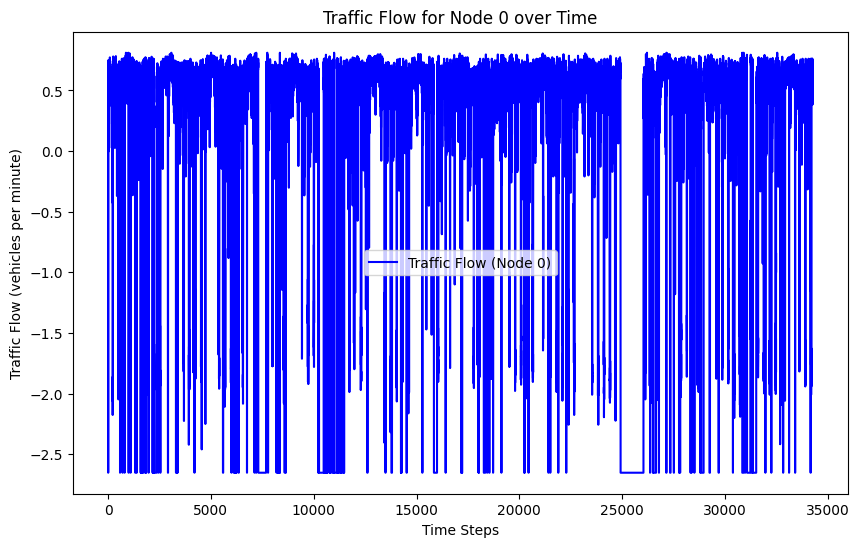

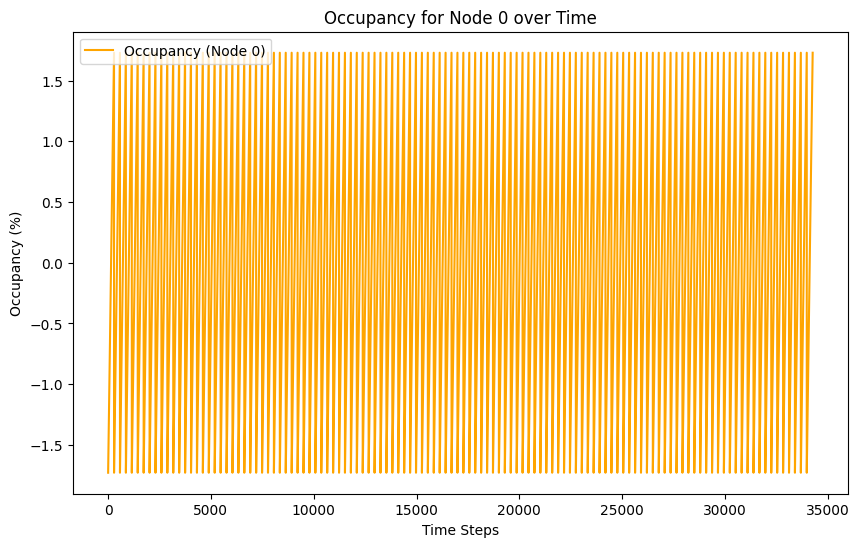

In [8]:
# Visualizing the first feature (Traffic Flow) for node 0
plt.figure(figsize=(10, 6))
plt.plot(X[0, 0, :], label='Traffic Flow (Node 0)', color='blue')
plt.title("Traffic Flow for Node 0 over Time")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Flow (vehicles per minute)")
plt.legend()
plt.show()

# Visualizing the second feature (Occupancy) for node 0
plt.figure(figsize=(10, 6))
plt.plot(X[0, 1, :], label='Occupancy (Node 0)', color='orange')
plt.title("Occupancy for Node 0 over Time")
plt.xlabel("Time Steps")
plt.ylabel("Occupancy (%)")
plt.legend()
plt.show()


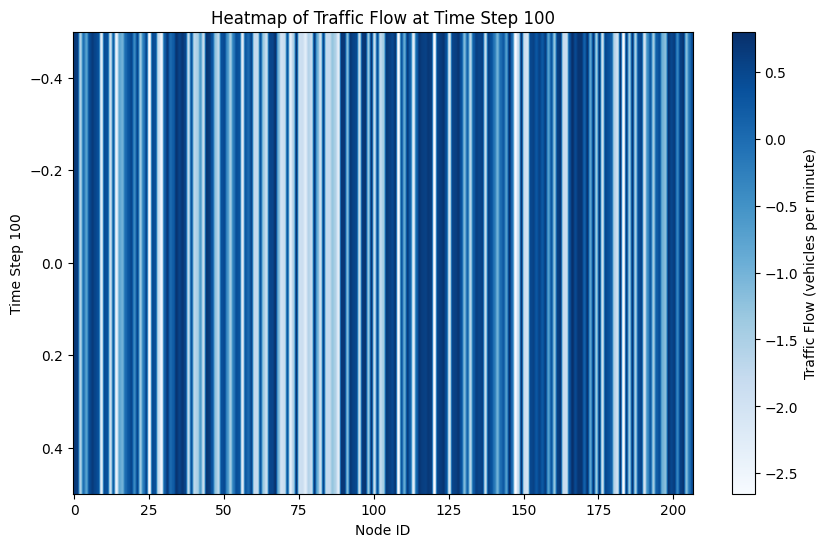

In [9]:
# Plotting a heatmap of the traffic flow for a specific time step (e.g., time step 100)
plt.figure(figsize=(10, 6))
plt.imshow(X[:, 0, 100].reshape(1, num_nodes), cmap="Blues", aspect="auto")
plt.colorbar(label="Traffic Flow (vehicles per minute)")
plt.title("Heatmap of Traffic Flow at Time Step 100")
plt.xlabel("Node ID")
plt.ylabel("Time Step 100")
plt.show()


In [10]:
# Compute summary statistics for traffic flow (feature 0) and occupancy (feature 1)
traffic_flow_mean = np.mean(X[:, 0, :], axis=1)
traffic_flow_std = np.std(X[:, 0, :], axis=1)

occupancy_mean = np.mean(X[:, 1, :], axis=1)
occupancy_std = np.std(X[:, 1, :], axis=1)

print(f"Traffic Flow - Mean: {traffic_flow_mean[:5]}, Std: {traffic_flow_std[:5]} (first 5 nodes)")
print(f"Occupancy - Mean: {occupancy_mean[:5]}, Std: {occupancy_std[:5]} (first 5 nodes)")


Traffic Flow - Mean: [ 0.05105368  0.33910397  0.35262948 -0.20164737 -0.3720849 ], Std: [1.1192082  0.79021066 0.90614396 0.7839237  0.95745677] (first 5 nodes)
Occupancy - Mean: [-1.8119628e-05 -1.8119628e-05 -1.8119628e-05 -1.8119628e-05
 -1.8119628e-05], Std: [1.0018145 1.0018145 1.0018145 1.0018145 1.0018145] (first 5 nodes)


In [11]:
# Correlation between Traffic Flow and Occupancy for Node 0
correlation = np.corrcoef(X[0, 0, :], X[0, 1, :])[0, 1]
print(f"Correlation between Traffic Flow and Occupancy for Node 0: {correlation}")


Correlation between Traffic Flow and Occupancy for Node 0: -0.037511365929168636


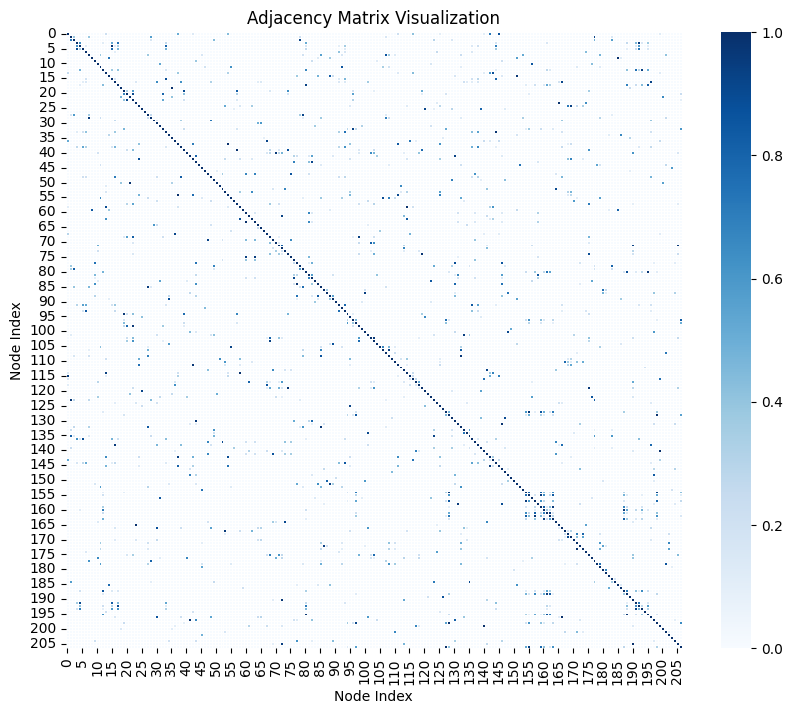

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

A = np.load("data/adj_mat.npy")
# A should be a square matrix of shape (207, 207) representing connections between nodes

plt.figure(figsize=(10, 8))

# Use seaborn's heatmap to visualize the adjacency matrix
sns.heatmap(A, cmap='Blues', square=True, linewidths=0.5, cbar=True)

plt.title("Adjacency Matrix Visualization")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()


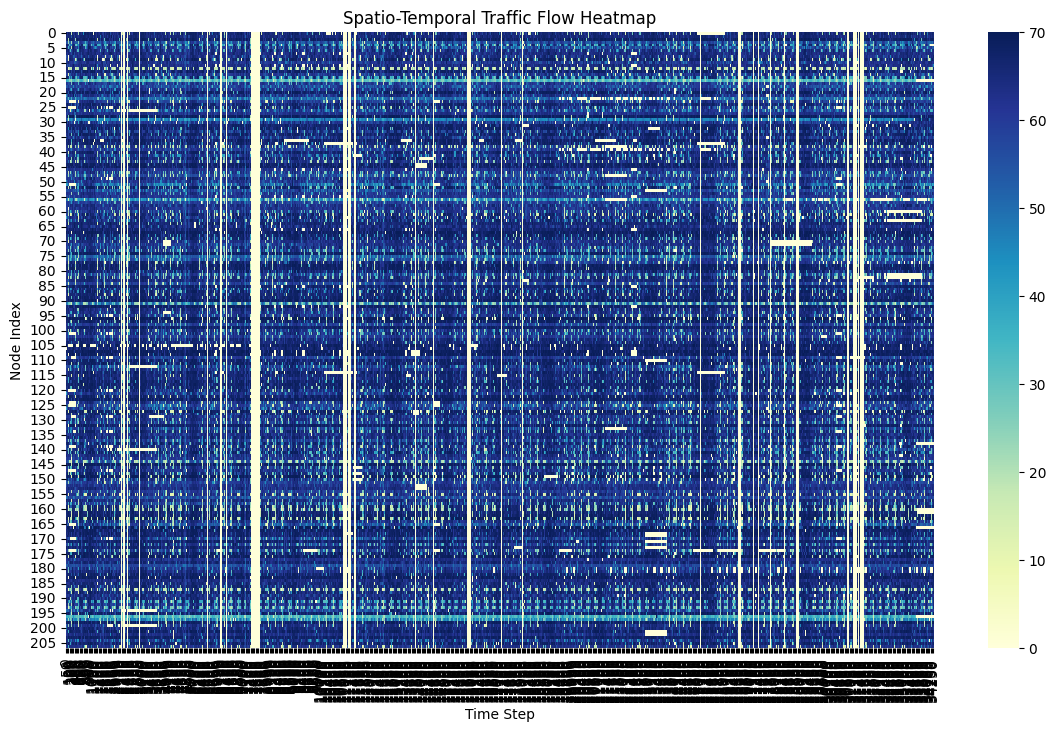

In [15]:
# Assuming 'X' has shape (207, 2, 34272)
plt.figure(figsize=(14, 8))
sns.heatmap(X[:, 0, :], cmap='YlGnBu', xticklabels=50)
plt.title("Spatio-Temporal Traffic Flow Heatmap")
plt.xlabel("Time Step")
plt.ylabel("Node Index")
plt.show()


## Data Pre-processing

In [16]:
# Check for missing values in the dataset
import numpy as np
import pandas as pd

# Convert node values into a pandas DataFrame for better visualization
df = pd.DataFrame(X[0, 0, :])  # For simplicity, taking the first node's data

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values for each time step:")
print(missing_values)


Missing values for each time step:
0    0
dtype: int64


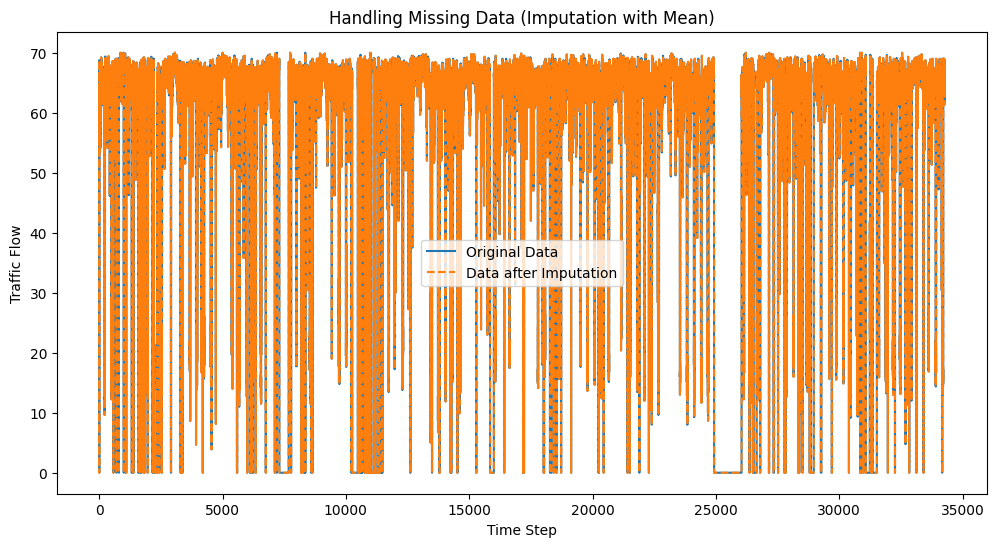

In [17]:
# Handling missing values - Impute missing values with the mean of each column
# If you need to impute across all time steps (across the 34272 points), here's an example
df_filled = df.fillna(df.mean())

# If you want to handle missing values by dropping rows with NaN values (less common):
# df_dropped = df.dropna()

# Visualize before and after filling missing values
plt.figure(figsize=(12, 6))
plt.plot(df[0], label="Original Data")
plt.plot(df_filled[0], label="Data after Imputation", linestyle="--")
plt.title("Handling Missing Data (Imputation with Mean)")
plt.xlabel("Time Step")
plt.ylabel("Traffic Flow")
plt.legend()
plt.show()
## No missing values

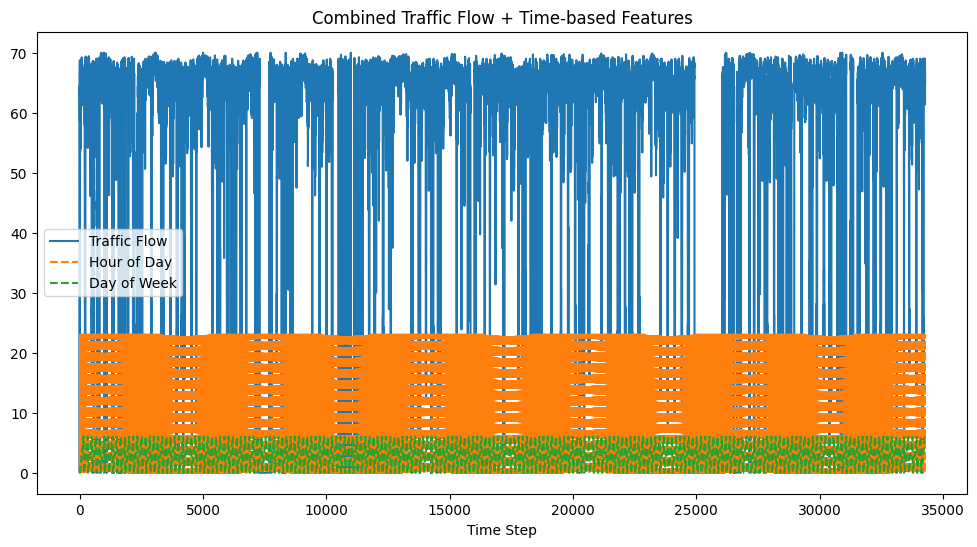

In [18]:
# Create time-based features (e.g., Hour of the day, Day of the week)
time_steps = np.arange(X.shape[2])

# Add 'hour_of_day' as a feature (assuming hourly data, you can modify it based on your data)
hour_of_day = time_steps % 24  # Assuming each time step corresponds to an hour

# Add day_of_week feature
day_of_week = (time_steps // 24) % 7  # Assuming each day has 24 time steps

# Create a new feature matrix
features = np.vstack((hour_of_day, day_of_week)).T  # Shape: (34272, 2)

# Combine the features with the traffic flow data for node 0 (or any other node)
node_data = X[0, 0, :]
combined_features = np.vstack((node_data, features[:, 0], features[:, 1])).T  # Traffic + Time features

# Visualizing combined data
plt.figure(figsize=(12, 6))
plt.plot(combined_features[:, 0], label="Traffic Flow")
plt.plot(combined_features[:, 1], label="Hour of Day", linestyle='--')
plt.plot(combined_features[:, 2], label="Day of Week", linestyle='--')
plt.title("Combined Traffic Flow + Time-based Features")
plt.xlabel("Time Step")
plt.legend()
plt.show()


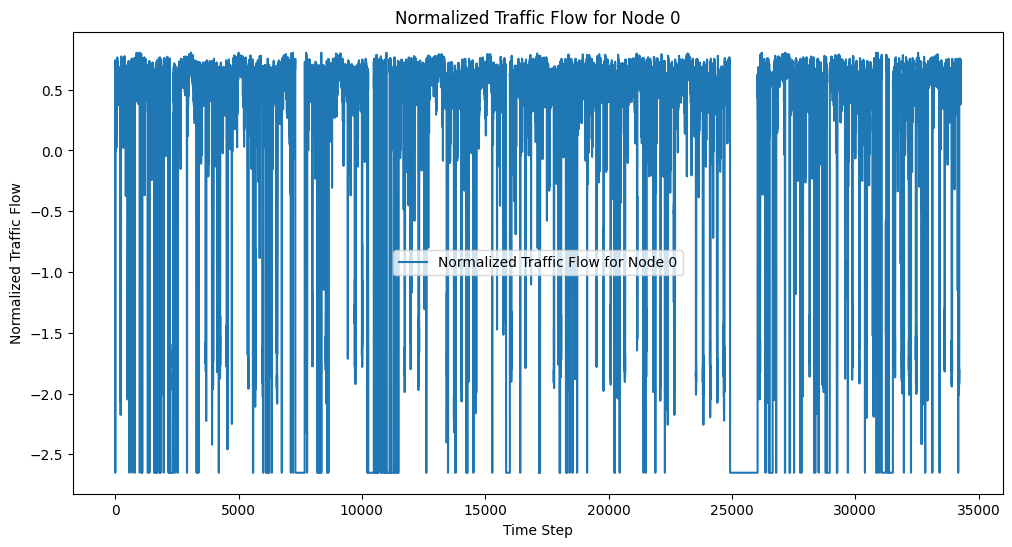

In [19]:
# Normalization using Z-score method for all the nodes (for each feature)
means = np.mean(X, axis=(0, 2))
X_normalized = X - means.reshape(1, -1, 1)
stds = np.std(X, axis=(0, 2))
X_normalized = X_normalized / stds.reshape(1, -1, 1)

# Plotting the normalized data for node 0 (optional)
plt.figure(figsize=(12, 6))
plt.plot(X_normalized[0, 0, :], label="Normalized Traffic Flow for Node 0")
plt.title("Normalized Traffic Flow for Node 0")
plt.xlabel("Time Step")
plt.ylabel("Normalized Traffic Flow")
plt.legend()
plt.show()


In [20]:
import os
import zipfile
import numpy as np

def load_metr_la_data():
    if (not os.path.isfile("data/adj_mat.npy")
            or not os.path.isfile("data/node_values.npy")):
        with zipfile.ZipFile("data/METR-LA.zip", 'r') as zip_ref:
            zip_ref.extractall("data/")

    # Load adjacency matrix and node values
    A = np.load("data/adj_mat.npy")
    X = np.load("data/node_values.npy").transpose((1, 2, 0))
    X = X.astype(np.float32)

    # Normalization using Z-score method
    means = np.mean(X, axis=(0, 2))
    X = X - means.reshape(1, -1, 1)
    stds = np.std(X, axis=(0, 2))
    X = X / stds.reshape(1, -1, 1)

    return A, X, means, stds


In [21]:
def get_normalized_adj(A):
    """
    Returns the degree normalized adjacency matrix.
    """
    # Add self-loops (identity matrix)
    A = A + np.diag(np.ones(A.shape[0], dtype=np.float32))

    # Compute the degree of each node (sum of rows)
    D = np.array(np.sum(A, axis=1)).reshape((-1,))
    D[D <= 10e-5] = 10e-5    # Prevent infs

    # Degree normalization
    diag = np.reciprocal(np.sqrt(D))  # Inverse square root of degree
    A_wave = np.multiply(np.multiply(diag.reshape((-1, 1)), A),
                         diag.reshape((1, -1)))  # Degree-normalized adjacency matrix
    return A_wave


In [22]:
import torch
import numpy as np

def generate_dataset(X, num_timesteps_input, num_timesteps_output):
    """
    Takes node features for the graph and divides them into multiple samples
    along the time-axis by sliding a window of size (num_timesteps_input+
    num_timesteps_output) across it in steps of 1.

    :param X: Node features of shape (num_vertices, num_features, num_timesteps)
    :param num_timesteps_input: Number of time steps used as input
    :param num_timesteps_output: Number of time steps to predict (output)

    :return:
        - Node features divided into multiple samples. Shape is
          (num_samples, num_vertices, num_features, num_timesteps_input).
        - Node targets for the samples. Shape is
          (num_samples, num_vertices, num_features, num_timesteps_output).
    """
    # Generate the beginning index and the ending index of a sample, which
    # contains (num_points_for_training + num_points_for_predicting) points
    indices = [(i, i + (num_timesteps_input + num_timesteps_output)) for i
               in range(X.shape[2] - (
                num_timesteps_input + num_timesteps_output) + 1)]

    # Save samples
    features, target = [], []
    for i, j in indices:
        features.append(
            X[:, :, i: i + num_timesteps_input].transpose(
                (0, 2, 1)))  # Transposing to (num_vertices, num_timesteps_input, num_features)
        target.append(X[:, 0, i + num_timesteps_input: j])  # Using the first feature for prediction

    return torch.from_numpy(np.array(features)), \
           torch.from_numpy(np.array(target))


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(TimeBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X):
        X = X.permute(0, 3, 1, 2)
        temp = self.conv1(X) + torch.sigmoid(self.conv2(X))
        out = F.relu(temp + self.conv3(X))
        return out.permute(0, 2, 3, 1)



class STGCNBlock(nn.Module):
    def __init__(self, in_channels, spatial_channels, out_channels, num_nodes):
        super(STGCNBlock, self).__init__()
        self.temporal1 = TimeBlock(in_channels=in_channels, out_channels=out_channels)
        self.Theta1 = nn.Parameter(torch.FloatTensor(out_channels, spatial_channels))
        self.temporal2 = TimeBlock(in_channels=spatial_channels, out_channels=out_channels)
        self.batch_norm = nn.BatchNorm2d(num_nodes)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Theta1.shape[1])
        self.Theta1.data.uniform_(-stdv, stdv)

    def forward(self, X, A_hat):
        t = self.temporal1(X)
        lfs = torch.einsum("ij,jklm->kilm", [A_hat, t.permute(1, 0, 2, 3)])
        t2 = F.relu(torch.matmul(lfs, self.Theta1))
        t3 = self.temporal2(t2)
        return self.batch_norm(t3)

class STGCN(nn.Module):
    def __init__(self, num_nodes, num_features, num_timesteps_input, num_timesteps_output):
        super(STGCN, self).__init__()
        self.block1 = STGCNBlock(in_channels=num_features, out_channels=64, spatial_channels=16, num_nodes=num_nodes)
        self.block2 = STGCNBlock(in_channels=64, out_channels=64, spatial_channels=16, num_nodes=num_nodes)
        self.last_temporal = TimeBlock(in_channels=64, out_channels=64)
        self.fully = nn.Linear((num_timesteps_input - 2 * 5) * 64, num_timesteps_output)

    def forward(self, A_hat, X):
        out1 = self.block1(X, A_hat)
        out2 = self.block2(out1, A_hat)
        out3 = self.last_temporal(out2)
        return self.fully(out3.reshape((out3.shape[0], out3.shape[1], -1)))

In [24]:
# Replace with your data loading functions
A, X, means, stds = load_metr_la_data()

split_line1 = int(X.shape[2] * 0.6)  # 60% of timesteps
split_line2 = int(X.shape[2] * 0.8)  # 80% of timesteps

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

# Normalize adjacency matrix
A_wave = torch.from_numpy(get_normalized_adj(A)).to(device)

In [26]:
# Set constants
use_gpu = True
num_timesteps_input = 12
num_timesteps_output = 3
epochs = 100
batch_size = 8

# Configure device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [27]:
# Number of samples to use (first 1000 samples)
num_samples = 2000

# Generate the datasets
training_input, training_target = generate_dataset(
    train_original_data,
    num_timesteps_input=num_timesteps_input,
    num_timesteps_output=num_timesteps_output
)
val_input, val_target = generate_dataset(
    val_original_data,
    num_timesteps_input=num_timesteps_input,
    num_timesteps_output=num_timesteps_output
)
test_input, test_target = generate_dataset(
    test_original_data,
    num_timesteps_input=num_timesteps_input,
    num_timesteps_output=num_timesteps_output
)

# Slice to only the first 1000 samples
training_input, training_target = training_input[:num_samples], training_target[:num_samples]
val_input, val_target = val_input[:num_samples], val_target[:num_samples]
test_input, test_target = test_input[:num_samples], test_target[:num_samples]


In [28]:
net = STGCN(A_wave.shape[0], training_input.shape[3], num_timesteps_input, num_timesteps_output).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_criterion = nn.MSELoss()

In [29]:
def train_epoch(training_input, training_target, batch_size, net, A_wave, optimizer, loss_criterion, device):
    permutation = torch.randperm(training_input.shape[0])
    epoch_training_losses = []
    for i in range(0, training_input.shape[0], batch_size):
        net.train()
        optimizer.zero_grad()
        indices = permutation[i:i + batch_size]
        X_batch, y_batch = training_input[indices], training_target[indices]
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out = net(A_wave, X_batch)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        epoch_training_losses.append(loss.detach().cpu().numpy())
    return sum(epoch_training_losses) / len(epoch_training_losses)


Epoch 0, Training Loss: 0.3955, Validation Loss: 0.3215, MAE: 7.1878
Epoch 1, Training Loss: 0.2866, Validation Loss: 0.3349, MAE: 6.3786
Epoch 2, Training Loss: 0.2716, Validation Loss: 0.3120, MAE: 6.5319
Epoch 3, Training Loss: 0.2517, Validation Loss: 0.3245, MAE: 6.0956
Epoch 4, Training Loss: 0.2504, Validation Loss: 0.2754, MAE: 5.7294
Epoch 5, Training Loss: 0.2422, Validation Loss: 0.2747, MAE: 5.4685
Epoch 6, Training Loss: 0.2288, Validation Loss: 0.3004, MAE: 6.9952
Epoch 7, Training Loss: 0.2271, Validation Loss: 0.2858, MAE: 6.1918
Epoch 8, Training Loss: 0.2232, Validation Loss: 0.2582, MAE: 5.3781
Epoch 9, Training Loss: 0.2256, Validation Loss: 0.2832, MAE: 5.5330
Epoch 10, Training Loss: 0.2284, Validation Loss: 0.2584, MAE: 5.3324
Epoch 11, Training Loss: 0.2164, Validation Loss: 0.2529, MAE: 5.0769
Epoch 12, Training Loss: 0.2142, Validation Loss: 0.2736, MAE: 6.2578
Epoch 13, Training Loss: 0.2163, Validation Loss: 0.2521, MAE: 5.5859
Epoch 14, Training Loss: 0.217

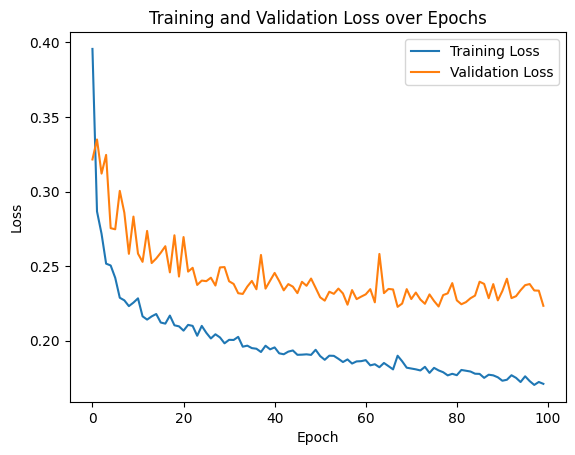

In [30]:
training_losses, validation_losses, validation_maes = [], [], []

for epoch in range(epochs):
    loss = train_epoch(training_input, training_target, batch_size, net, A_wave, optimizer, loss_criterion, device)
    training_losses.append(loss)

    # Validation step
    with torch.no_grad():
        net.eval()
        val_input, val_target = val_input.to(device), val_target.to(device)
        out = net(A_wave, val_input)
        val_loss = loss_criterion(out, val_target).cpu().item()
        validation_losses.append(val_loss)

        # Unnormalize and calculate MAE
        out_unorm, target_unorm = out.cpu().numpy() * stds[0] + means[0], val_target.cpu().numpy() * stds[0] + means[0]
        mae = np.mean(np.abs(out_unorm - target_unorm))
        validation_maes.append(mae)

    # Print epoch results
    print(f"Epoch {epoch}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, MAE: {mae:.4f}")

# Plot the losses after all epochs
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.show()



In [31]:
os.makedirs("checkpoints", exist_ok=True)  # Creates the 'checkpoints' directory if it doesn't exist
with open("checkpoints/losses.pk", "wb") as fd:
    pk.dump((training_losses, validation_losses, validation_maes), fd)  # Save losses to a file
torch.save(net.state_dict(), "checkpoints/stgcn_model.pt")  # Save model weights


<ipython-input-32-44f9b05e5aff>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("checkpoints/stgcn_model.pt"))


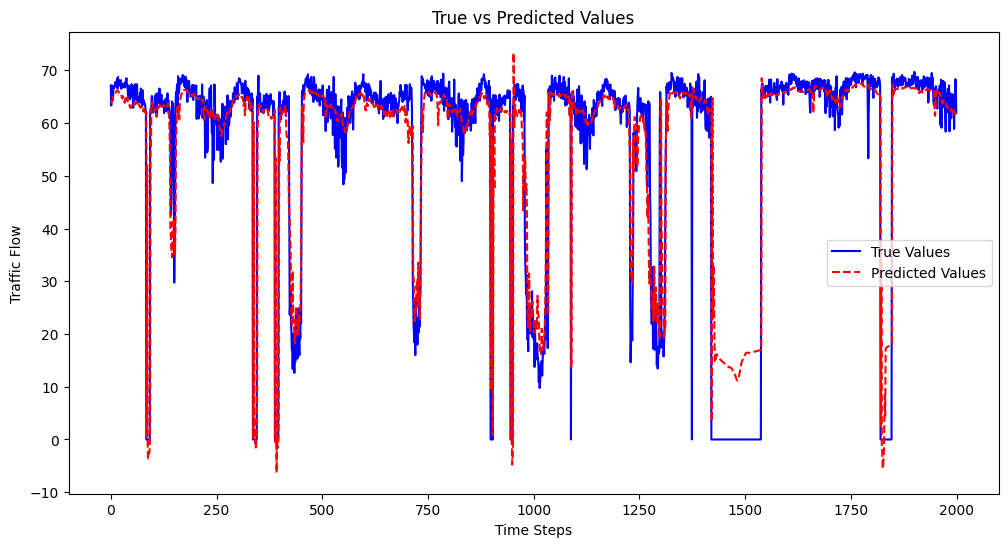

In [32]:
# Step 1: Load the saved model if not already in memory
net = STGCN(A_wave.shape[0], training_input.shape[3], num_timesteps_input, num_timesteps_output).to(device)
net.load_state_dict(torch.load("checkpoints/stgcn_model.pt"))
net.eval()

# Step 2: Select a subset of the test data
test_input = test_input.to(device)
test_target = test_target.to(device)

# Step 3: Run the model to get predictions
with torch.no_grad():
    predicted_output = net(A_wave, test_input)

# Convert predictions and targets back to original scale using mean and std deviation
predicted_output = predicted_output.cpu().numpy() * stds[0] + means[0]
test_target = test_target.cpu().numpy() * stds[0] + means[0]

# Step 4: Plot True vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_target[:, 0, 0], label='True Values', color='blue')  # Plotting for the first node only
plt.plot(predicted_output[:, 0, 0], label='Predicted Values', color='red', linestyle='--')  # Same node as above

plt.title('True vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Flow')
plt.legend()
plt.show()
